# Pretrained Models

## Base learners using pretrained models

### Base learners using Resnet152, AlexNet, Densenet161

Built using the function that Tyler created
The tb_preprocess.py script should be in the same folder as the notebook.

##### Need to add other models

In [2]:
modelnames = {'alexnet':'alexnet','resnet152':'resnet152','densenet161':'densenet161'}

#Set the Model name
model_param = 'inception_v3'
filepath = '.'

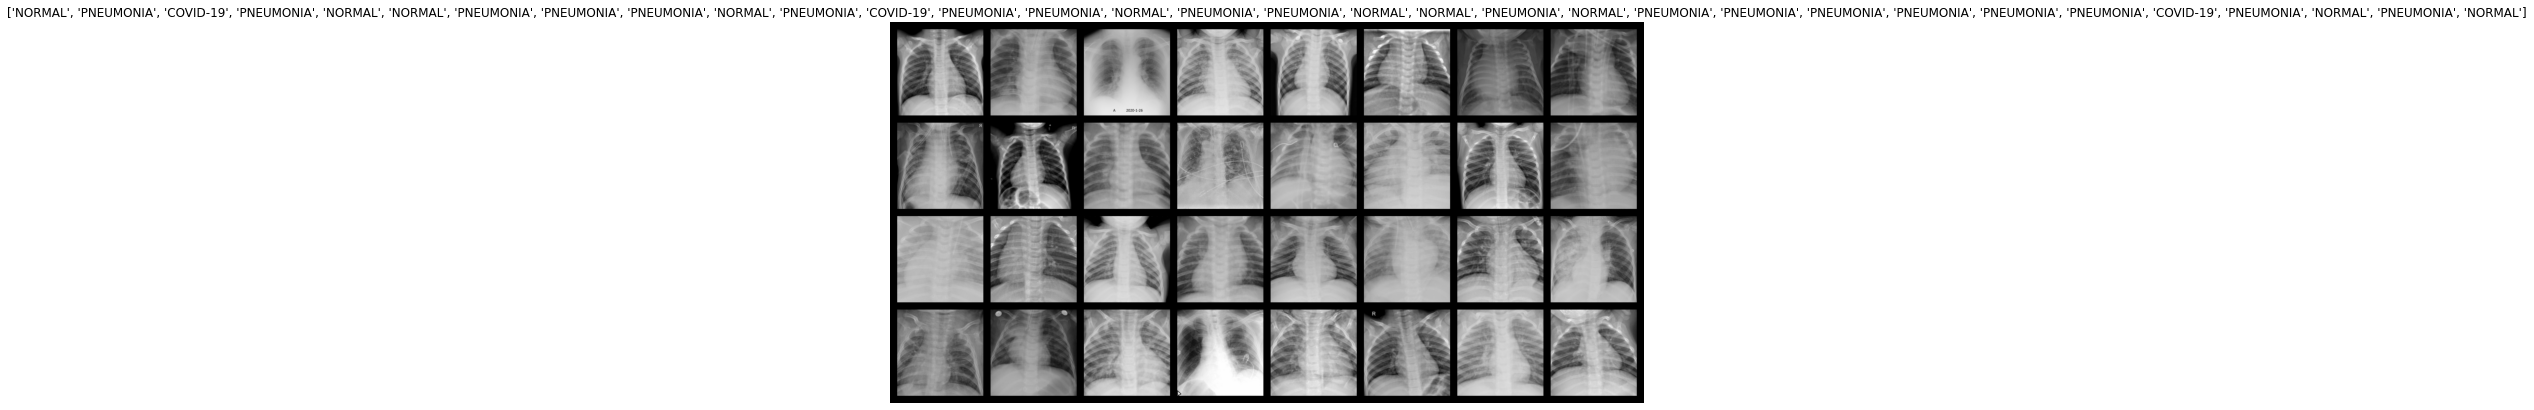

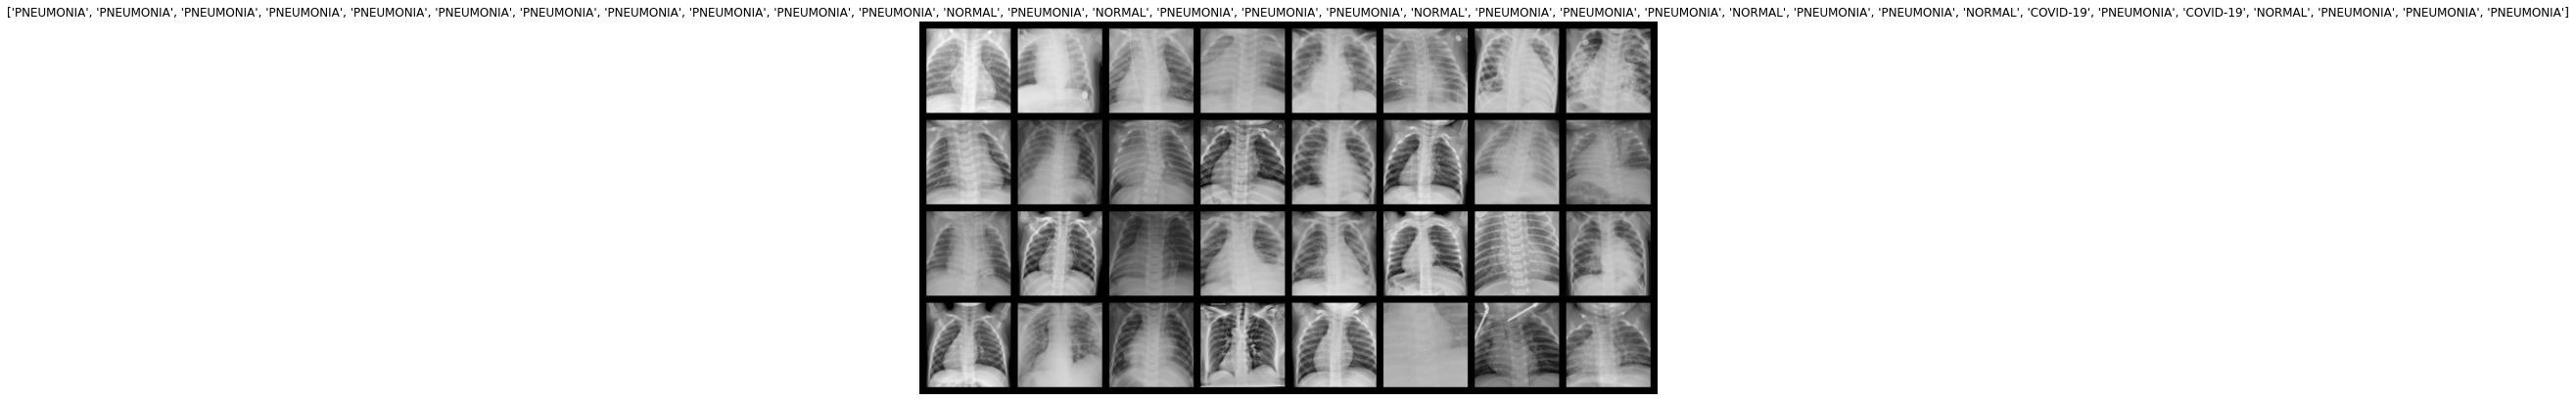

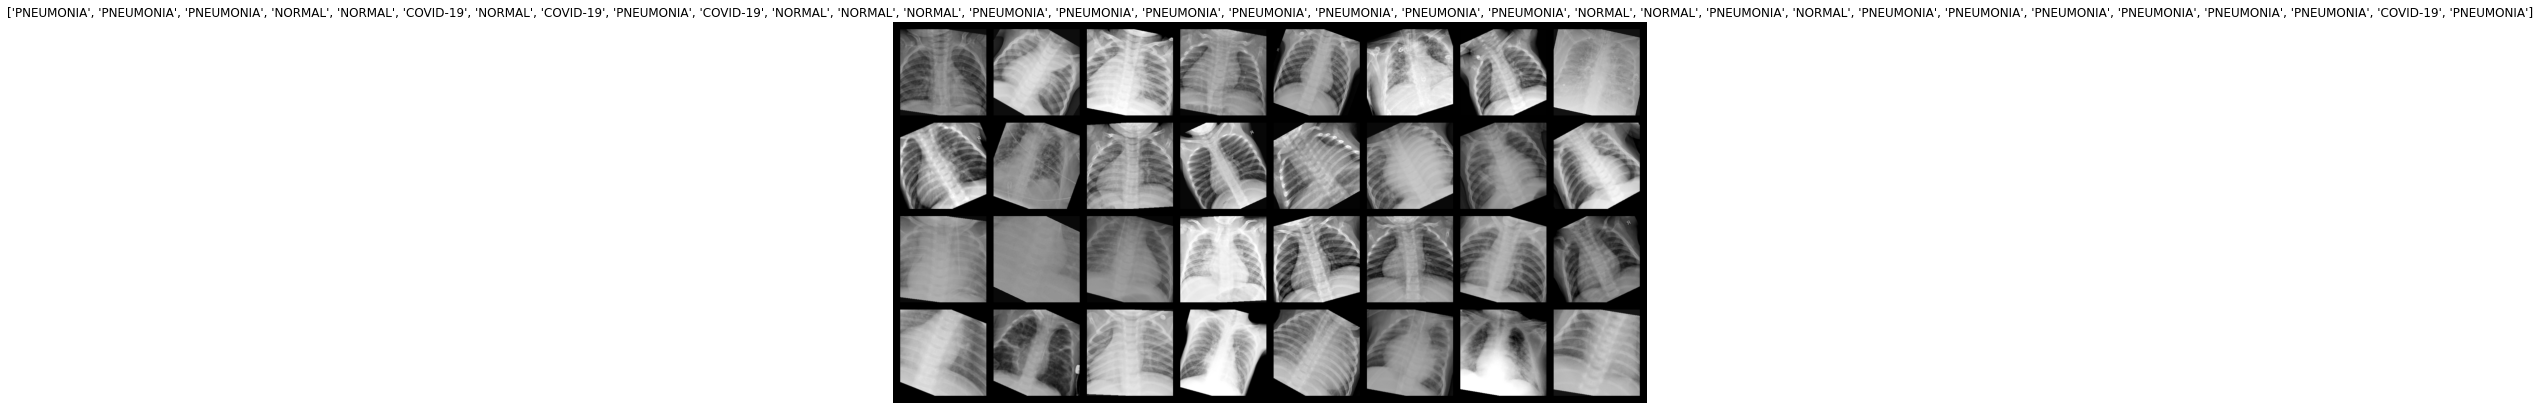

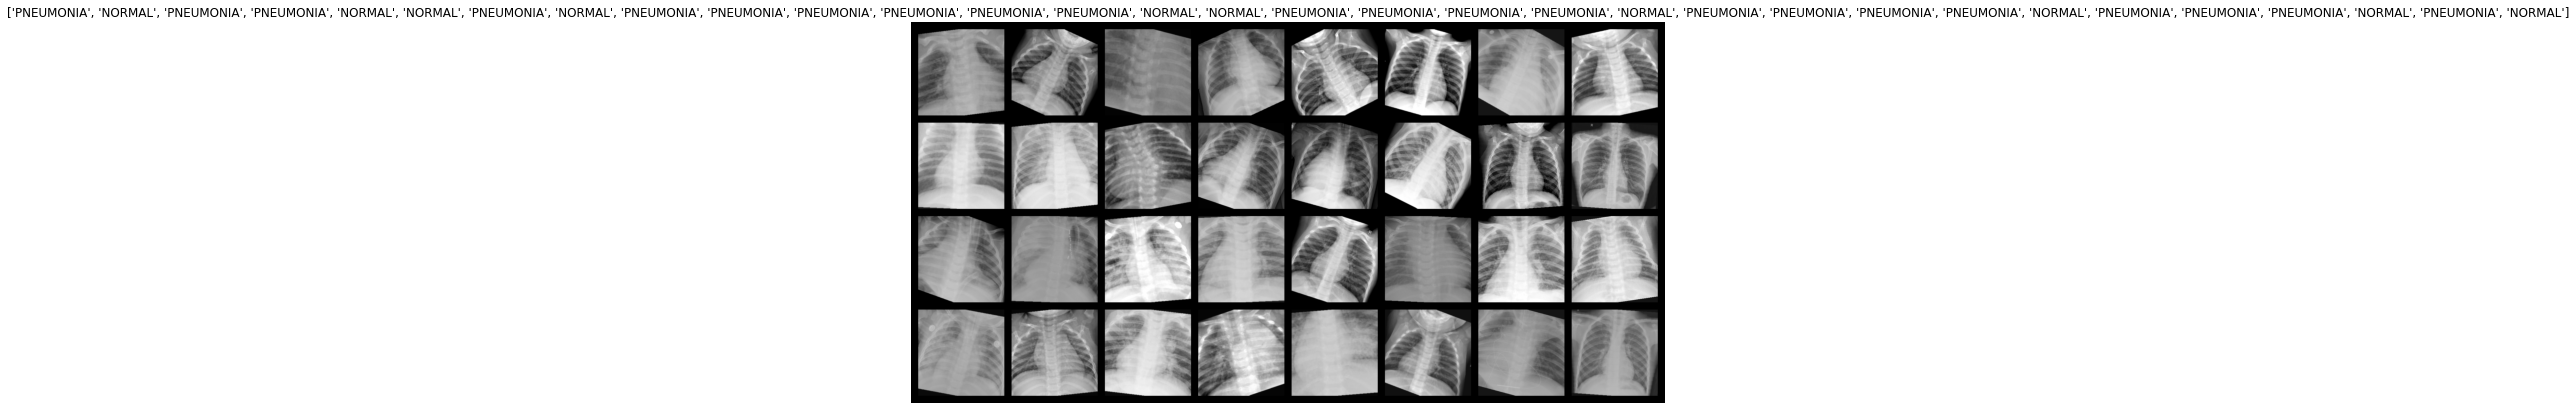

In [3]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time; _START_RUNTIME = time.time()
import gc

from torchvision import models


#Use the preprocess function from tb_preprocess.py to load the datasets
from preprocess import load_data

train_loader, val_loader, train_loader_red, val_loader_red = load_data() 
  

idx2class = {'covid-19': 0, 'normal': 1, 'pnuemonia': 2}
classes = ('Covid-19', 'Normal', 'Pneumonia')



### Use the model that is pretrained. 

##### Model selection is hardcoded for now


In [4]:
gc.collect()
torch.cuda.empty_cache()

red_model = models.__dict__[model_param](pretrained=True,aux_logits=False)

#Instantiating CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Verifying CUDA
print(device)



#Move the input and model to GPU for speed if available
red_model.to(device)


NameError: name 'gc' is not defined

#### Change the last linear layer to match the number of classes. In this case 3.

##### Eg:- The standard Alexnet model has 1000 out features for the last Linear layer. Since the data set only has 3 classes, change the last layer to have 3 outs

In [ ]:

if model_param == 'alexnet':
    red_model.classifier[6] = torch.nn.Linear(red_model.classifier[6].in_features, 3, bias=True)
elif model_param == 'resnet152':
    red_model.fc = torch.nn.Linear(2048, 3, bias=True)
elif model_param == 'densenet161':
    red_model.classifier = torch.nn.Linear(2208, 3, bias=True)
elif model_param == "inception_v3":
    red_model.fc = torch.nn.Linear(2048, 3, bias=True)
        
red_model.eval()


if model_param == 'alexnet':
    red_model.features = torch.nn.DataParallel(red_model.features)
    red_model.cuda()
else:
    red_model = torch.nn.DataParallel(red_model).cuda()
    

#### Criterion and Optimizer

In [ ]:
import torch.optim as optim

#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD(red_model.parameters(), lr=0.001, momentum=0.9)

### Training inceptionv3


In [ ]:
#Epochs is set to 1. Performace is slow
#Need to try CUDA to speed up

n_epochs = 25

print('Model training')

def train_model(model, train_dataloader, n_epoch=n_epochs, optimizer=optimizer, criterion=criterion):
    import torch.optim as optim

    # prep model for training
    model.train() 
    
    for epoch in range(n_epoch):
        
        EPOCH_START = time.time()
        
        curr_epoch_loss = []
        
        for data, target in train_dataloader:
            
            data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            
            output = model(data)
            #print(output)
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
            
            curr_epoch_loss.append(loss.cpu().data.numpy())
            
        print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
        print("Training time = {:.2f} seconds".format(time.time() - EPOCH_START))
    
    return model


### Save the model

In [1]:

trainedmodel = model_param + '.pth'

if os.path.exists(trainedmodel):
    print('Model is trained - ' + model_param)
    red_model = torch.load(trainedmodel)
else:
    red_model = train_model(red_model, train_loader)
    torch.save(red_model, trainedmodel)
    print("Total running time = {:.2f} seconds".format(time.time() - _START_RUNTIME))
    
gc.collect()
torch.cuda.empty_cache() 


NameError: name 'model_param' is not defined

#### Testing

In [ ]:
def eval_model(model, dataloader):

    model.eval()
    Y_pred = []
    Y_test = []
    for data, target in dataloader:

        data, target = data.cuda(), target.cuda()
        
        output = model(data)
        #print(output.data)
        #print(target)
        _, y_predicted = torch.max(output.data, 1)
        
        Y_pred = np.append(Y_pred,y_predicted.detach().cpu().numpy())
        Y_test = np.append(Y_test,target.detach().cpu().numpy())

    return Y_pred, Y_test

from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred, y_true = eval_model(red_model, val_loader)
acc = accuracy_score(y_true, y_pred)

print(("Validation Accuracy: " + str(acc)))

# Classification Report
print(classification_report(y_true, y_pred))

# Confusion Matrix
print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_pred)).rename(columns=idx2class, index=idx2class)

cm = confusion_matrix(y_true, y_pred)
#print(cm)

print('Confusion Matrix Display')
cm_display = ConfusionMatrixDisplay(cm,classes).plot()


## Testing Accuracy

Classification accuracy of the test model.

In [ ]:

correct = 0
total = 0

# no_grad impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = red_model(images)
        #print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test X-rays : %d %%' % ( 100 * correct / total))



## Individual Classes


In [ ]:
#Testing classification accuracy for individual classes.
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))

with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = red_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(3):
    print('Accuracy of %5s : %2d %%' % (
         classes[i], 100 * class_correct[i] / class_total[i]))
